# Load Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
import random

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
url = "https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentiment_opini_film.csv"
data = pd.read_csv(url)

In [3]:
data.head()

,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


In [4]:
data.describe()

,Id
count,200.000000
mean,100.500000
std,57.879185
min,1.000000
25%,50.750000
50%,100.500000
75%,150.250000
max,200.000000


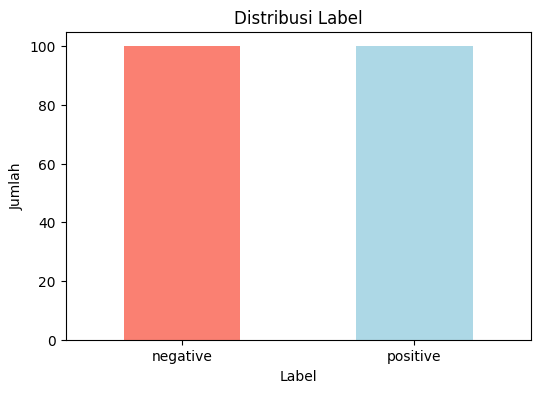

In [5]:
# Visualisasi distribusi label
plt.figure(figsize=(6,4))
data['Sentiment'].value_counts().plot(kind='bar', color=['salmon', 'lightblue'])
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.show()

# PRE-PROCESSING

In [6]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# pre-processing
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Hapus Url
    text = re.sub(r'\@\w+|\#', '', text)  # Hapus mention dan hastag
    text = re.sub(r'[^\w\s]', '', text) # Hapus tanda baca
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) # Hapus karakter non-alfanumerik
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi ganda
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Hapus Karakter non-ASCII
    text = text.lower()

    # Tokenize text dan hapus stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Memanggil Fungsi preprocess_text
data['Text_Clean'] = data['Text Tweet'].apply(preprocess_text)

In [8]:
# Encoding Label
label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])

In [9]:
data.head(5)

,Id,Sentiment,Text Tweet,Text_Clean
0,1,0,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek filmnya apalagi si ernest gak mutu bgt a...
1,2,0,Film king Arthur ini film paling jelek dari se...,film king arthur ini film paling jelek dari se...
2,3,0,@beexkuanlin Sepanjang film gwa berkata kasar ...,sepanjang film gwa berkata kasar terus pada ba...
3,4,0,Ane ga suka fast and furious..menurutku kok je...,ane ga suka fast furiousmenurutku kok jelek ya...
4,5,0,"@baekhyun36 kan gua ga tau film nya, lu bilang...",kan gua ga tau film nya lu bilang perang peran...


In [10]:
# Augmentation function: Random Deletion
def augment_text_random_deletion(text, p=0.3):
    """Randomly delete words in the text with probability p."""
    words = text.split()
    if len(words) == 1:  # Mengembalikan original text
        return text
    retained_words = [word for word in words if random.random() > p]
    if len(retained_words) == 0:  # Data kosong karena fungsi
        retained_words = [random.choice(words)]
    return ' '.join(retained_words)

In [11]:
# Apply text augmentation
data['augmented_tweet'] = data['Text_Clean'].apply(lambda x: augment_text_random_deletion(x))

In [12]:
data.head(5)

,Id,Sentiment,Text Tweet,Text_Clean,augmented_tweet
0,1,0,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek filmnya apalagi si ernest gak mutu bgt a...,jelek filmnya apalagi ernest bgt actingnya sampah
1,2,0,Film king Arthur ini film paling jelek dari se...,film king arthur ini film paling jelek dari se...,film arthur ini film paling seluruh king arthur
2,3,0,@beexkuanlin Sepanjang film gwa berkata kasar ...,sepanjang film gwa berkata kasar terus pada ba...,sepanjang film kasar terus pada bapaknya
3,4,0,Ane ga suka fast and furious..menurutku kok je...,ane ga suka fast furiousmenurutku kok jelek ya...,ane suka fast furiousmenurutku kok jelek ya tu...
4,5,0,"@baekhyun36 kan gua ga tau film nya, lu bilang...",kan gua ga tau film nya lu bilang perang peran...,kan ga film nya lu bilang perang perangan dise...


In [13]:
# Combine original and augmented data for training
all_texts = data['Text_Clean'].tolist() + data['augmented_tweet'].tolist()
all_labels = data['Sentiment'].tolist() * 2  # Duplicate labels for augmented data

In [14]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts)
sequences = tokenizer.texts_to_sequences(all_texts)
padded_sequences = pad_sequences(sequences, maxlen=20, padding='post', truncating='post')

In [15]:
# Convert labels to numpy array
labels = np.array(all_labels)

In [16]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [17]:
# Model Sequential
model = Sequential([
    Embedding(input_dim=1000, output_dim=128, input_length=100),
    LSTM(128),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(3, activation='sigmoid'),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Uji Model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.4142 - loss: 1.0342 - val_accuracy: 0.5500 - val_loss: 0.7619
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5108 - loss: 0.7389 - val_accuracy: 0.5625 - val_loss: 0.6872
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5055 - loss: 0.7209 - val_accuracy: 0.7125 - val_loss: 0.6579
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5751 - loss: 0.6694 - val_accuracy: 0.7125 - val_loss: 0.5877
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7948 - loss: 0.5169 - val_accuracy: 0.9500 - val_loss: 0.2488
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9568 - loss: 0.1620 - val_accuracy: 0.9125 - val_loss: 0.3266
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9740 - loss: 0.0840 - val_accuracy: 0.9250 - val_loss: 0.3830
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9892 - loss: 0.0385 - val_accuracy: 0.9125 - v

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9297 - loss: 0.4260
Test Accuracy: 0.9375
Test Loss: 0.38640713691711426


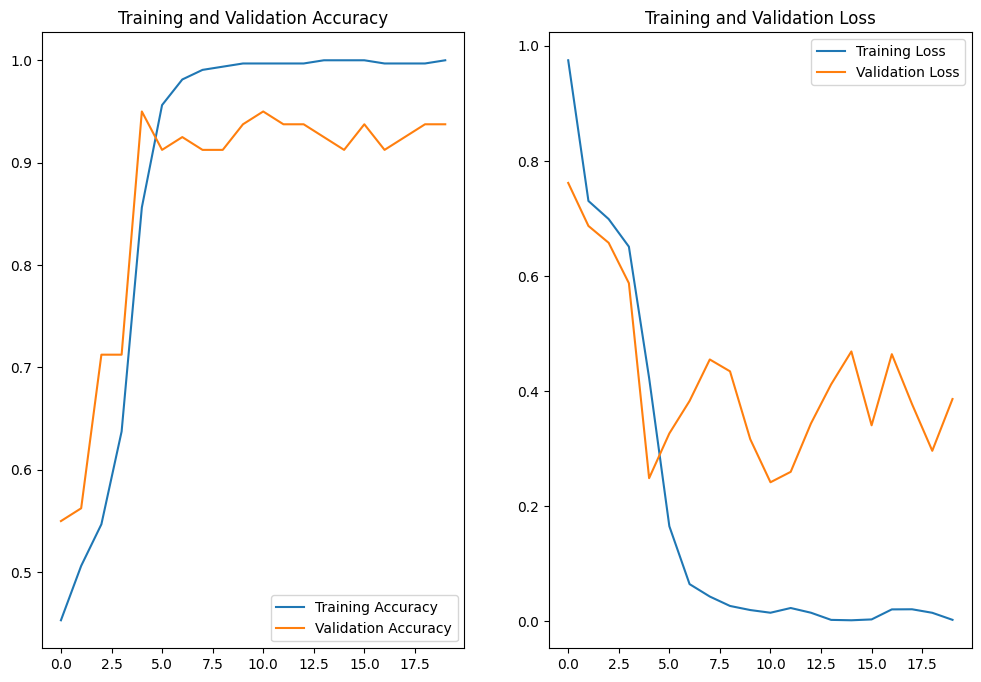

In [21]:
# Memplot akurasi dan loss pelatihan dan validasi
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()